In [1]:
%matplotlib inline
# Importing standard Qiskit libraries
import qiskit

from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

from qiskit import QuantumRegister
from qiskit import ClassicalRegister
from qiskit.circuit import Parameter

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

import numpy as np

In [2]:
numOfInputs = 2
numOfOutputs = 2

In [3]:
# Function: Creates Controlled-NOT Gates (CNOT) and Barriers for aesthetics 
# Parameters: 'circuit', 'channels'
#     'circuit' : quantum circuit 
#    'channels' : number of active states in circuit (generally same as 'numIn')
def CNOT_and_Barriers(circuit, channels):
    for channel in range(channels-1):
        circuit.cx(channel, channel+1)
        for count in range(channel):
            circuit.barrier(count)

def clusterStateQC(numIn, numOut):    
    # Define Cluster State Quantum Circuit (abbreviated: cs_qc) 
    # numIn = number of initial quantum states 
    # numOut = number of output states of cs_qc (likely same as numIn)
    cs_qc = QuantumCircuit(numIn, numOut)
    #cs_qc.add_register(quReg)
    
    # Hadamard Gates for all incoming feature inputs to achieve superposition of states
    #for num in range(numIn):
     #   cs_qc.h(quReg[num])
    cs_qc.h(range(numIn))
        
    # Place Controlled-NOT Gates (CNOT) for entanglement and barriers for aesthetics
    CNOT_and_Barriers(cs_qc, numIn)
    
    # Place Pauli-Y Gates (Y) for rotation of states about y-axis 
    #for num in range(numIn):
    #    cs_qc.y(quReg[num])
    cs_qc.y(range(numIn))
    
    # Place Controlled-NOT Gates (CNOT) for entanglement and barriers for aesthetics
    CNOT_and_Barriers(cs_qc, numIn)  
    
    cs_qc.barrier()
    
    return cs_qc

In [4]:
def qConvLayer1(shift, prm1, prm2, prm3, prm4, inputs):
    qConv = QuantumCircuit(inputs, inputs)
    for i in range(inputs):
        index = int(i)
        qConv.u(prm1, prm2, prm3, index)
    for i in range(inputs-1):
        if (i%2==0):
            qConv.cx(i,i+1)
    return qConv

def qConvLayer2(shift, prm1, prm2, prm3, prm4, inputs):
    qConv = QuantumCircuit(inputs, inputs)
    for i in range(0+shift,inputs-1,2):
        index = int(i)
        if (i%2==shift):
            qConv.cu(prm1, prm2, prm3, prm4, control_qubit=index, target_qubit=index+1)
    return qConv

In [5]:
def qPoolLayer(inputs, outputs, shift=0):
    qPool = QuantumCircuit(inputs, outputs)
    if shift == 0: 
        for i in range(inputs):
            qPool.measure(i, i)
        return qPool
    for i in range(inputs):
        if (i%2==shift):
            qPool.measure(i, i)
    return qPool

In [6]:
class MyQuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        
        self._circuit = QuantumCircuit(n_qubits)

        self.theta = Parameter('θ')
        self.phi = Parameter('Φ')
        self.lam = Parameter('λ')
        self.gamma = Parameter('γ')
        
        nIn = n_qubits
        nOut = nIn
        shift = 0
        
        self._circuit += clusterStateQC(numIn=nIn, numOut=nOut)
        self._circuit += qConvLayer1(0, self.theta, self.phi, self.lam, self.gamma, nIn)
        self._circuit += qConvLayer2(0, self.theta, self.phi, self.lam, self.gamma, nIn)
        #self._circuit += qConvLayer2(1, self.theta, self.phi, self.lam, self.gamma, nIn)
        self._circuit.barrier()
        self._circuit += qPoolLayer(nIn, nOut, 1)
        self._circuit.barrier()
        self._circuit += qConvLayer2(0, self.theta, self.phi, self.lam, self.gamma, nIn)
        self._circuit.barrier()
        self._circuit += qPoolLayer(nIn, nOut, 0)        
        
        # ---------------------------

        self.backend = backend
        self.shots = shots
           
    def run(self, val_range):
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: val1, self.phi: val2, self.lam: val3, self.gamma: val4} 
                                            for (val1, val2, val3, val4) in [np.linspace(0,np.pi/2,4,dtype=float)]])
        #[np.linspace(0,np.pi,4,dtype=int)]
        #[{self.theta: val, self.phi: val, self.lam: val, self.gamma: val} 
        #                                   for val in val_range]
        
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])

<ipython-input-6-8294d989cc99>:20: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  self._circuit += clusterStateQC(numIn=nIn, numOut=nOut)
/opt/conda/lib/python3.8/site-packages/qiskit/circuit/quantumcircuit.py:876: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)


Expected value for rotation pi 5.130000000000001
ParameterView([Parameter(Φ), Parameter(γ), Parameter(θ), Parameter(λ)])


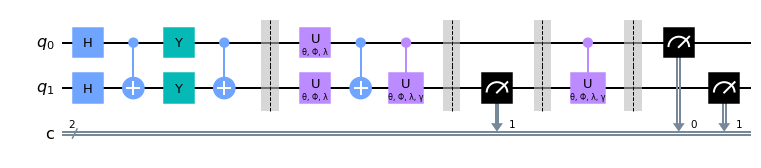

In [7]:
simulator = qiskit.Aer.get_backend('qasm_simulator')

circuit = MyQuantumCircuit(2, simulator, 100)
print('Expected value for rotation pi {}'.format(circuit.run([np.linspace(0,np.pi / 2,4,dtype=float)])[0]))
circuit._circuit.draw()
print(circuit._circuit.parameters)

In [8]:
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [9]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input.tolist())
        #print(len(input.tolist()))
        #print(input)
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        #print(input.shape)
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = MyQuantumCircuit(numOfInputs, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        #print(self.parameters)
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [11]:
# Concentrating on the first 100 samples
n_samples = 20

X_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1 
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...


/opt/conda/lib/python3.8/site-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


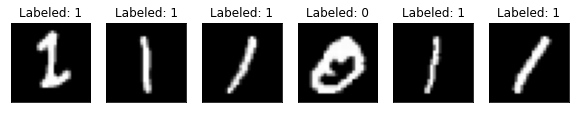

In [12]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
    n_samples_show -= 1

In [13]:
n_samples = 50

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 1)
        self.hybrid = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)

In [16]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#from qiskit.aqua.components.optimizers import AQGD
#optimizer = AQGD
print(model.parameters)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []

print(model)

qc = QuantumCircuit()

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        #optimizer.optimize(4, )
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))

<bound method Module.parameters of Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (hybrid): Hybrid()
)>
Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (hybrid): Hybrid()
)


<ipython-input-9-fc7149bd8039>:35: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  gradients = np.array([gradients]).T


Training [5%]	Loss: -0.4450
Training [10%]	Loss: -0.6097
Training [15%]	Loss: -0.6730
Training [20%]	Loss: -0.4495
Training [25%]	Loss: -0.4838
Training [30%]	Loss: -0.4998
Training [35%]	Loss: -0.4855
Training [40%]	Loss: -0.5242
Training [45%]	Loss: -0.6298
Training [50%]	Loss: -0.3660
Training [55%]	Loss: -0.5398
Training [60%]	Loss: -0.5268
Training [65%]	Loss: -0.5418
Training [70%]	Loss: -0.4970
Training [75%]	Loss: -0.4185
Training [80%]	Loss: -0.5488
Training [85%]	Loss: -0.6622
Training [90%]	Loss: -0.5330
Training [95%]	Loss: -0.3380
Training [100%]	Loss: -0.4270


Text(0, 0.5, 'Neg Log Likelihood Loss')

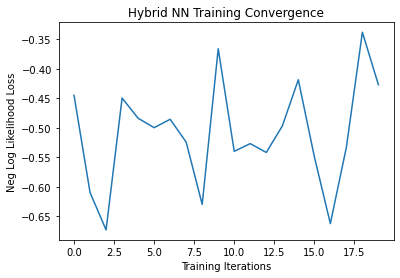

In [17]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [18]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: -0.4595
	Accuracy: 50.0%


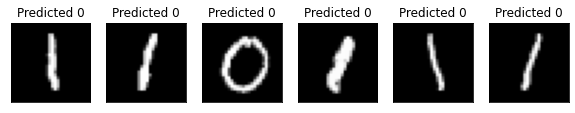

In [34]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        
        count += 1